<a href="https://colab.research.google.com/github/Durbagio/Homework-1-CMLS/blob/master/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Audio Effects

# General Discussion

### Importing libraries and database

In [0]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython
import IPython.display as ipd
import scipy as sp
import multiprocessing as mp

Remember to create a shortcut in your drive to the shared "Project 1" folder

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset cardinality

In [0]:
classes = ['NoFX', 'Distortion', 'Tremolo']

for c in classes:
    root='/content/drive/My Drive/Project 1/Dataset/Gitarre polyphon/Samples/{}'.format(c)
    class_files = [f for f in os.listdir(root) if f.endswith('.wav')]
    print('Guitar poly, {},'.format(c), len(class_files))
    root='/content/drive/My Drive/Project 1/Dataset/Gitarre monophon/Samples/{}'.format(c)
    class_files = [f for f in os.listdir(root) if f.endswith('.wav')]
    print('Guitar mono, {},'.format(c), len(class_files))
    root='/content/drive/My Drive/Project 1/Dataset/Bass monophon/Samples/{}'.format(c)
    class_files = [f for f in os.listdir(root) if f.endswith('.wav')]
    print('Bass mono, {},'.format(c), len(class_files))

Guitar mono, NoFX, 420
Guitar poly, NoFX, 624
Bass mono, NoFX, 624
Guitar mono, Distortion, 1260
Guitar poly, Distortion, 1872
Bass mono, Distortion, 1872
Guitar mono, Tremolo, 1260
Guitar poly, Tremolo, 1872
Bass mono, Tremolo, 1872


### Feature Computation
Spectral Rolloff, Spectral RMS, Zero Crossing Rate, Spectral Centroid, Spectral Bandwidth, Spectral Contrast, Spectral Flatness, Harmonic RMS, Hi-End RMS, Mel Spectrogram, Mel-frequency Cepstral Coefficients (14).

In [0]:
def harmonic_rms (signal):
    # Extract the harmonics
    harmonics = librosa.effects.harmonic(signal)
    # Calculate the rms of the harmonics only
    rms_value = np.mean(librosa.feature.rms(harmonics))

    return rms_value

In [0]:
def hi_end_rms (signal, Fs):

    # Setup window values and allocate array
    win_length = int(np.floor(0.01 * Fs))
    hop_size = int(np.floor(0.0075 * Fs))
    window = sp.signal.get_window(window='hanning', Nx=win_length)
    win_number = int(np.floor((signal.shape[0] - win_length) / hop_size))

    rms_frame = np.zeros((win_number))

    for i in np.arange(win_number):
        # Compute the frame
        frame = signal[i * hop_size : i * hop_size + win_length]
        frame_wind = frame * window
    
        # Compute the spectrogram of this frame
        spec = np.fft.fft(frame_wind)
        nyquist = int(np.floor(spec.shape[0] / 2))
        spec = spec[1:nyquist]

        # Design the high pass
        filt = sp.signal.butter(2, 1200, fs=Fs, btype='highpass', output='sos')
        # Filter the signal
        hi_end = sp.signal.sosfilt(filt, spec)
        # Compute the rms value
        rms_frame = librosa.feature.rms(y=None, S=spec)
    
    # Average the value of whole signal
    rms_hi_end = np.mean(rms_frame)

    return rms_hi_end   

In [0]:
classes = ['NoFX', 'Distortion', 'Tremolo']
class_features={'NoFX':[],'Distortion':[],'Tremolo':[]}

frame_len= 8192
win_len=2048 
hop_len=512

# Number of Mel-frequency cepstral coefficients
n_mfcc = 14 
n_features = 10+n_mfcc

feature_names = ['Spectral Rolloff','RMS','ZCR','Spectral Centroid', 'Bandwidth', 'Spectral Contrast', 'Spectral Flatness', 'Harmonic RMS', 'High End RMS', 'MEL Spectrogram', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8','MFCC9','MFCC10','MFCC11','MFCC12','MFCC13','MFCC14']

for c in classes:
    # Find the folder (select between Guitar monophonic, Guitar poliphonic, Bass monophonic)
    root='/content/drive/My Drive/Project 1/Dataset/Gitarre monophon/Samples/{}'.format(c)
    # root='/content/drive/My Drive/Project 1/Dataset/Gitarre polyphon/Samples/{}'.format(c)
    # root='/content/drive/My Drive/Project 1/Dataset/Bass monophon/Samples/{}'.format(c)
    
    # List the files
    class_files = [f for f in os.listdir(root) if f.endswith('.wav')]
    class_files = class_files[0: 600]

    # Declare the number of feature and files and allocate the array
    n_files = len(class_files)

    features = np.zeros((n_files, n_features))

    for index, f in enumerate(class_files):
        # Load the file
        audio, fs = librosa.load(os.path.join(root, f), sr=None)

        # Compute the features, take the mean value on all the frames, save them in the features array
        features[index, 0] = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=fs, S=None, n_fft=win_len, hop_length=hop_len))
        features[index, 1] = np.mean(librosa.feature.rms(y=audio, S=None, frame_length=win_len, hop_length=hop_len))
        features[index, 2] = np.mean(librosa.feature.zero_crossing_rate(audio, frame_length=win_len, hop_length=hop_len))
        features[index, 3] = np.mean(librosa.feature.spectral_centroid(y = audio,sr = fs,S = None,n_fft = win_len, hop_length = hop_len))
        features[index, 4] = np.mean(librosa.feature.spectral_bandwidth(y = audio,sr = fs,S = None,n_fft = win_len, hop_length = hop_len))
        features[index, 5] = np.mean(librosa.feature.spectral_contrast(y = audio,sr = fs,S = None,n_fft = win_len, hop_length = hop_len))
        features[index, 6] = np.mean(librosa.feature.spectral_flatness(y = audio, S = None,n_fft = win_len, hop_length = hop_len))
        features[index, 7] = harmonic_rms(audio)
        features[index, 8] = hi_end_rms(audio, fs)
        features[index, 9] = np.mean(librosa.feature.melspectrogram(y = audio, sr = fs, S = None,n_fft = win_len, hop_length = hop_len))
        features[index, 10:] = np.mean(librosa.feature.mfcc(y=audio, sr=fs, S=None, n_mfcc=n_mfcc, dct_type=2, norm='ortho'), axis=1)

    # Store features in the class features array
    class_features[c] = features
    print("Ok for class {}".format(c))

Ok for class NoFX
Ok for class Distortion
Ok for class Tremolo


### Implementing the model

DB

In [0]:
# Declaring the features matrix of each class (X) and its label (Y)

# No effect
X_noFX = class_features['NoFX']
y_noFX = np.zeros((X_noFX.shape[0],))

# Distortion
X_Dist = class_features['Distortion']
y_Dist = np.ones((X_Dist.shape[0],))

# Tremolo
X_Trem = class_features['Tremolo']
y_Trem = np.ones((X_Trem.shape[0],))*2

# Concatenate all (features and labels)
X = np.concatenate((X_noFX, X_Dist, X_Trem), axis=0)
Y = np.concatenate((y_noFX, y_Dist, y_Trem), axis = 0)

#### SVC

In [0]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.feature_selection import  SelectKBest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

All features

In [18]:
# Defining the pipeline to avoid data leakage
pipe = make_pipeline(StandardScaler(), SVC(C = 20, kernel = 'rbf', probability = True))

# Define the cv split
split = StratifiedKFold(n_splits=5, shuffle=True)

# Train and predict
svc_prediction = cross_val_predict(estimator = pipe, X = X, y = Y, cv=split)

# Print the results
classes1 = {'NoFX':0,'Distortion':1,'Tremolo':2}
print(classification_report(Y, svc_prediction, target_names = classes1.keys()))

              precision    recall  f1-score   support

        NoFX       0.99      0.98      0.98       600
  Distortion       1.00      1.00      1.00       600
     Tremolo       0.98      0.99      0.98       600

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



In [19]:
#Confusion matrix (SVM, all features)
confusion_matrix(Y, svc_prediction)

array([[586,   0,  14],
       [  0, 600,   0],
       [  6,   0, 594]])

Feature Selection

Text(0, 0.5, 'Cross-Validated Accuracy')

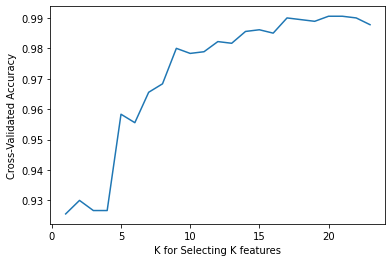

In [24]:
#Define the cv split
split = StratifiedKFold(n_splits=5, shuffle=True)

#Selection of k best features:
n_range = range(1, n_features)
n_scores = []

for i in n_range:
    selector = SelectKBest(k = i)
    # Defining the pipeline to avoid data leakage
    pipe = make_pipeline(selector, StandardScaler(), SVC(C = 20, kernel = 'rbf', probability = True))

    scores = cross_val_score(pipe, X=X, y=Y, cv=split, scoring='accuracy')
    n_scores.append(scores.mean())

# Plot accuracy vs K features selected
plt.plot(n_range, n_scores)
plt.xlabel('K for Selecting K features')
plt.ylabel('Cross-Validated Accuracy')

In [60]:
#Define the CV split
split = StratifiedKFold(n_splits=5, shuffle=True)

#Feature selection
selector = SelectKBest(k = 20)

# Defining the pipeline to avoid data leakage
pipe = make_pipeline(selector, StandardScaler(), SVC(C = 20, kernel = 'rbf', probability = True))

#Train and predict
svc_prediction = cross_val_predict(estimator = pipe, X = X, y = Y, cv=split)

#Print the results
classes1 = {'NoFX':0,'Distortion':1,'Tremolo':2}
print(classification_report(Y, svc_prediction, target_names = classes1.keys()))

              precision    recall  f1-score   support

        NoFX       0.99      0.97      0.98       600
  Distortion       1.00      1.00      1.00       600
     Tremolo       0.97      0.99      0.98       600

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



In [61]:
#Confusion matrix 
confusion_matrix(Y, svc_prediction)

array([[584,   0,  16],
       [  0, 600,   0],
       [  5,   0, 595]])

#### K-Neighbors
All features

In [0]:
from sklearn.neighbors import KNeighborsClassifier

Text(0, 0.5, 'Cross-Validated Accuracy')

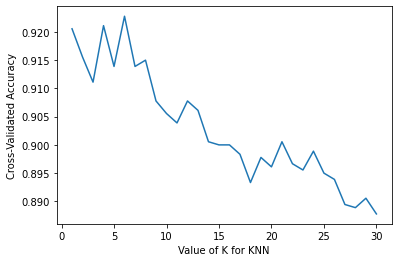

In [53]:
# Define the model
split = StratifiedKFold(n_splits=5, shuffle=True)

# Select number of neighbors (k)
n_range = range(1,31)
n_scores = []

for n in n_range: 
    knn = KNeighborsClassifier(n_neighbors=n, weights='distance') 

    # Defining the pipeline to avoid data leakage
    pipe = make_pipeline(knn)

    scores = cross_val_score(pipe, X=X, y=Y, cv=split, scoring='accuracy')
    n_scores.append(scores.mean())

# Plot accuracy vs K neighbors selected
plt.plot(n_range, n_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [63]:
# Define the model
knn = KNeighborsClassifier(n_neighbors=6, weights='distance')
split = StratifiedKFold(n_splits=5, shuffle=True)

# Defining the pipeline to avoid data leakage
pipe = make_pipeline(knn)

# Train and predict
knn_prediction = cross_val_predict(pipe, X=X, y=Y, cv=split)

# Print the results
classes1 = {'NoFX':0,'Distortion':1,'Tremolo':2}
print(classification_report(Y, knn_prediction, target_names = classes1.keys()))

              precision    recall  f1-score   support

        NoFX       0.87      0.88      0.87       600
  Distortion       1.00      0.99      1.00       600
     Tremolo       0.87      0.87      0.87       600

    accuracy                           0.91      1800
   macro avg       0.91      0.91      0.91      1800
weighted avg       0.91      0.91      0.91      1800



In [64]:
# Confusion matrix
confusion_matrix(Y, knn_prediction)

array([[526,   0,  74],
       [  2, 596,   2],
       [ 75,   1, 524]])

Feature selection

Text(0, 0.5, 'Cross-Validated Accuracy')

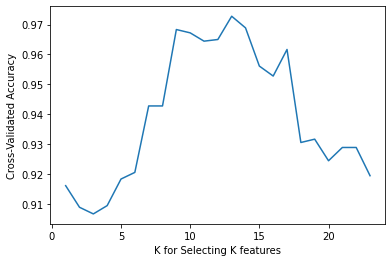

In [57]:
# Define the CV split
split = StratifiedKFold(n_splits=5, shuffle=True)

# Define the model
knn = KNeighborsClassifier(n_neighbors=6, weights='distance')

# Selection of K best features:
n_range = range(1, n_features)
n_scores = []

for i in n_range:
    selector = SelectKBest(k = i)

    # Defining the pipeline to avoid data leakage
    pipe = make_pipeline(selector, knn)

    scores = cross_val_score(pipe, X=X, y=Y, cv=split, scoring='accuracy')
    n_scores.append(scores.mean())

# Plot accuracy vs K features selected
plt.plot(n_range, n_scores)
plt.xlabel('K for Selecting K features')
plt.ylabel('Cross-Validated Accuracy')

In [65]:
# Selection of K best features:
selector = SelectKBest(k = 13)

# Define the model
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
split = StratifiedKFold(n_splits=5, shuffle=True)
pipe = make_pipeline(selector, knn)

# Train and predict
knn_prediction = cross_val_predict(pipe, X=X, y=Y, cv=split)

# Print the results
classes1 = {'NoFX':0,'Distortion':1,'Tremolo':2}
print(classification_report(Y, knn_prediction, target_names = classes1.keys()))

              precision    recall  f1-score   support

        NoFX       0.94      0.93      0.93       600
  Distortion       1.00      1.00      1.00       600
     Tremolo       0.93      0.94      0.93       600

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



In [66]:
# Confusion matrix
confusion_matrix(Y, knn_prediction)

array([[555,   0,  45],
       [  0, 600,   0],
       [ 38,   0, 562]])

#### Best features computation

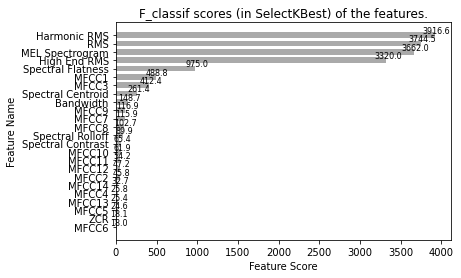

In [67]:
# Scoring
slct = SelectKBest(k="all")
slct.fit(X_norm, Y)
scores = slct.scores_

# Sort features by score from largest to smallest
named_scores = zip(feature_names, scores)
sorted_named_scores = sorted(named_scores, key=lambda z: z[1], reverse=True)
 
sorted_scores = [each[1] for each in sorted_named_scores]
sorted_names = [each[0] for each in sorted_named_scores]
 
y_pos = np.arange(len(feature_names))# drawing order from top to bottom

# Plot
fig, ax = plt.subplots()
ax.barh(y_pos, sorted_scores, height=0.7, align='center', color='#AAAAAA', tick_label=sorted_names)
ax.set_yticks(y_pos)
ax.set_xlabel('Feature Score')
ax.set_ylabel('Feature Name')
ax.invert_yaxis()
ax.set_title('F_classif scores (in SelectKBest) of the features.')

# Add the value for every line
for score, pos in zip(sorted_scores, y_pos):
        ax.text(score + 20, pos, '%.1f' % score, ha='center', va='bottom', fontsize=8)